## Spark ML : Linear Regression Example1


### Concepts :

* Creating RDD using SparkContext
* Providing schema to create a DataFrame from an RDD
* Performing basic data analysis using Spark SQL
* Using Spark ML to perform train a linear regression model

### Input Dataset :

* California Housing Dataset, housing prices per 'blocks' of census. Each row in the dataset corresponds to a block group. A block corresponds to a group of citizens that live in a geographically compact area

### Objective :

* Build a model that is able to predict the median house price

### Dataset Details:

Features : 

* Latitude 
* Longitude
* Housing median age : median age of the people that belong to a block group 
* Total rooms : total nb of rooms in the houses of the block group 
* Total bedrooms : total nb of bedrooms in the houses of the block group
* Population : nb of inhabitants of a block group 
* Households : units of houses and their occupants per block group 
* Median income : median income of people that belong to a block group 

Target :

* Median house value 

### Overall Workflow

1. Load Data
2. Inspect Data
3. Preprocess Data
4. Create Model
5. Make Predictions
6. Evaluate how good are our predictions

In [1]:
import os
my_home=os.environ['HOME']
dataset_path=my_home+"/spark-course/data/housing_data/"
outputs_path=my_home

In [2]:
import os
print(os.environ['SPARK_HOME'])

/usr/local/software/spark


In [3]:
import findspark
findspark.init()
import pyspark

In [4]:
# Create a SparkSession and specify configuration
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Lab5-ML-LinearRegression-Example") \
    .getOrCreate()

### Data Loading

Direct data inspection shows that the input data has no header.
There are several ways this can be tacked , I provide here only 2 examples on how to provide the schema, to construc the data frame
  * option 1 : use the Row object,construct a DataFrame by creating Row objects (remember a DataFrame is a Dataset[Row]
  * option 2 : infer the schema from the data and add a header
  * option 3 : there are possible other options , even simpler ... provide it yourself 

In [5]:
def readLine(line):
    """ Parse a line from the input data
    Args:
        line (str): a line (row) of the input data file
    Returns:
        Row : row object containin the parsed elements from the line
        Note we are adding schema by directly transforming the str into double types
    """
    
    parts=re.split(",", line)
   
    # Read in each feature PLUS THE TARGET
    lat = parts[0]
    lon = parts[1]
    age = parts[2]
    trm = parts[3]
    tbr = parts[4]
    pop = parts[5]
    hou = parts[6]
    inc = parts[7]
    val = parts[8]
        
    return Row(
                latitude=float(lat),
                longitude=float(lon),
                median_housing_age=float(age),
                total_rooms=float(trm),
                total_bedrooms=float(tbr),
                population=float(pop),
                households=float(hou),
                median_income=float(inc),
                median_value=float(val)
           )

In [6]:
# ---------
# Option 1 : use SparkContext and a function to map each line to a Row object
# ---------
from pyspark.sql import Row
import re
sc=spark.sparkContext
rdd = sc.textFile("file://"+dataset_path+"*.data")
#
df = rdd \
        .map(lambda line: readLine(line)) \
        .toDF()

In [7]:
df.show(10)

+----------+--------+---------+------------------+-------------+------------+----------+--------------+-----------+
|households|latitude|longitude|median_housing_age|median_income|median_value|population|total_bedrooms|total_rooms|
+----------+--------+---------+------------------+-------------+------------+----------+--------------+-----------+
|     126.0| -122.23|    37.88|              41.0|       8.3252|    452600.0|     322.0|         129.0|      880.0|
|    1138.0| -122.22|    37.86|              21.0|       8.3014|    358500.0|    2401.0|        1106.0|     7099.0|
|     177.0| -122.24|    37.85|              52.0|       7.2574|    352100.0|     496.0|         190.0|     1467.0|
|     219.0| -122.25|    37.85|              52.0|       5.6431|    341300.0|     558.0|         235.0|     1274.0|
|     259.0| -122.25|    37.85|              52.0|       3.8462|    342200.0|     565.0|         280.0|     1627.0|
|     193.0| -122.25|    37.85|              52.0|       4.0368|    2697

In [8]:
df.printSchema()

root
 |-- households: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- median_housing_age: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_value: double (nullable = true)
 |-- population: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- total_rooms: double (nullable = true)



In [9]:
# ---------
# Option 2 :  use SparkSession and infer schema, then add a header
# ---------

df2 = spark.read \
    .option("inferSchema", "true") \
    .csv("file://"+dataset_path+"*.data")
    
features=[ "latitude","longitude","median_housing_age", \
            "total_rooms","total_bedrooms","population", \
            "households","median_income"]
target=["median_value"]

fieldnames=features+target

rawnames=df2.schema.names

# Create a small function
def updateColNames(df,oldnames,newnames):
    for i in range(len(newnames)):
        df=df.withColumnRenamed(oldnames[i], newnames[i])
    return df

df2=updateColNames(df2,rawnames,fieldnames)

df2.printSchema()

root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- median_housing_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_value: double (nullable = true)



In [10]:
# Possibly also
# from pyspark.sql.types import *
# fieldnames=[ "latitude","longitude","median_housing_age", \
#            "total_rooms","total_bedrooms","population", \
#            "households","median_income","median_value"]
# fields = [StructField(field_name, DoubleType(), True) for field_name in fieldnames]
# schema = StructType(fields)
# features = rdd \
#            .map(lambda line: line.split(",")) 

In [11]:
# Create a table for SQL access
df.registerTempTable("houses")

### Data Inspection

In [12]:
# Records
df.count()

20640

In [13]:
# Summary statistics on the selected (or full) set of fields of the dataframe
# ( Remember the total rooms are PER GROPU BLOCK of census , not per house ..., obviously)
df.select('total_rooms','total_bedrooms','median_income','population').describe().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|       total_rooms|   total_bedrooms|     median_income|        population|
+-------+------------------+-----------------+------------------+------------------+
|  count|             20640|            20640|             20640|             20640|
|   mean|2635.7630813953488|537.8980135658915| 3.870671002906978|1425.4767441860465|
| stddev|2181.6152515827994|421.2479059431315|1.8998217179452634|1132.4621217653385|
|    min|               2.0|              1.0|            0.4999|               3.0|
|    max|           39320.0|           6445.0|           15.0001|           35682.0|
+-------+------------------+-----------------+------------------+------------------+



### Worth Noting Here

See here that the **standard deviation is in almost all cases of the order of the mean value**

**Meaning there is a large spread in our data** and pointing to the fact that we will need to somehow **normalize our data**

### Look for Correlations

In [14]:
# Create a small function
# that computes the correlation of each column against the target
# Computes Pearson Correlation Coefficient between the two columns
def computeCorrelation(df,targetColumnName):
    from pyspark.ml.stat import Correlation
    for col in df.columns:
        r=df.stat.corr(col,targetColumnName)
        print("Pearson correlation : %s %s %f \n" %(col,targetColumnName,r))

In [15]:
computeCorrelation(df, 'median_value')

Pearson correlation : households median_value 0.065843 

Pearson correlation : latitude median_value -0.045967 

Pearson correlation : longitude median_value -0.144160 

Pearson correlation : median_housing_age median_value 0.105623 

Pearson correlation : median_income median_value 0.688075 

Pearson correlation : median_value median_value 1.000000 

Pearson correlation : population median_value -0.024650 

Pearson correlation : total_bedrooms median_value 0.050594 

Pearson correlation : total_rooms median_value 0.134153 



### Data Visualization


You would typically take a sub sample (no replacement here) from the data JUST for plotting purposes.

Sampling with or without replacement has important statistical differences ( selection bias ), but we are jsut plotting

Usefull explanation of sample with or without replacement implications here:

https://www.ma.utexas.edu/users/parker/sampling/repl.htm

Linear Relationships (plotting):
https://seaborn.pydata.org/tutorial/regression.html

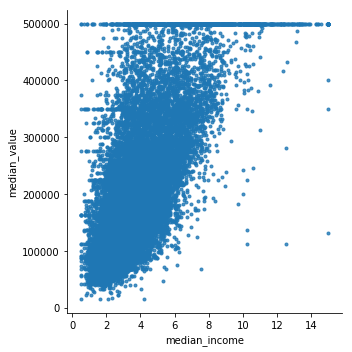

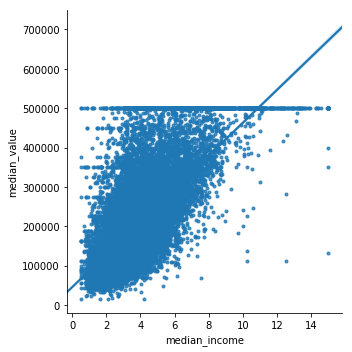

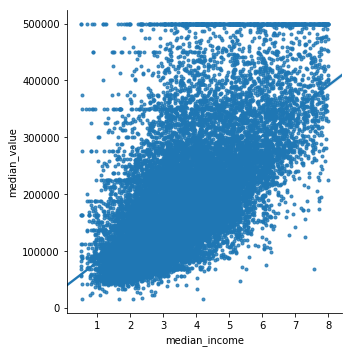

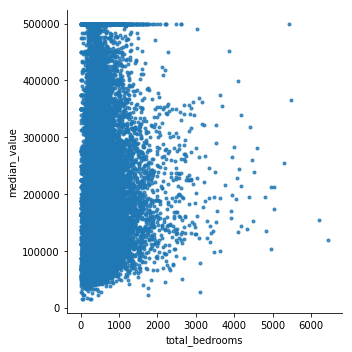

slope : 41793.849202
intercept : 45085.576703


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lmplot("median_income", "median_value", data=df.toPandas(), fit_reg=False,markers=".")
sns.lmplot("median_income", "median_value", data=df.toPandas(), fit_reg=True, markers=".")

#
# Note : 
# There seems to a nb of 'outliers' in this context
# meaning there are records with high income but low median_value
# those dont reflect the majority of your inputs for the model
# so i;m going to simply get rid of them for this purpose
#
my_df=df.filter(df['median_income']<8.0)

sns.lmplot("median_income", "median_value", data=my_df.toPandas(), fit_reg=True, markers=".")
sns.lmplot("total_bedrooms", "median_value", data=df.toPandas(), fit_reg=False, markers=".")
plt.show()


#
# Important Note : you will always want to normalize your data
# before doing this below , is there just for simple demo purposes
#

# Linear Regression Fits
import numpy as np
m,b = np.polyfit(df.toPandas()['median_income'], df.toPandas()['median_value'], 1)
print('slope : %f' % m)
print('intercept : %f' % b)

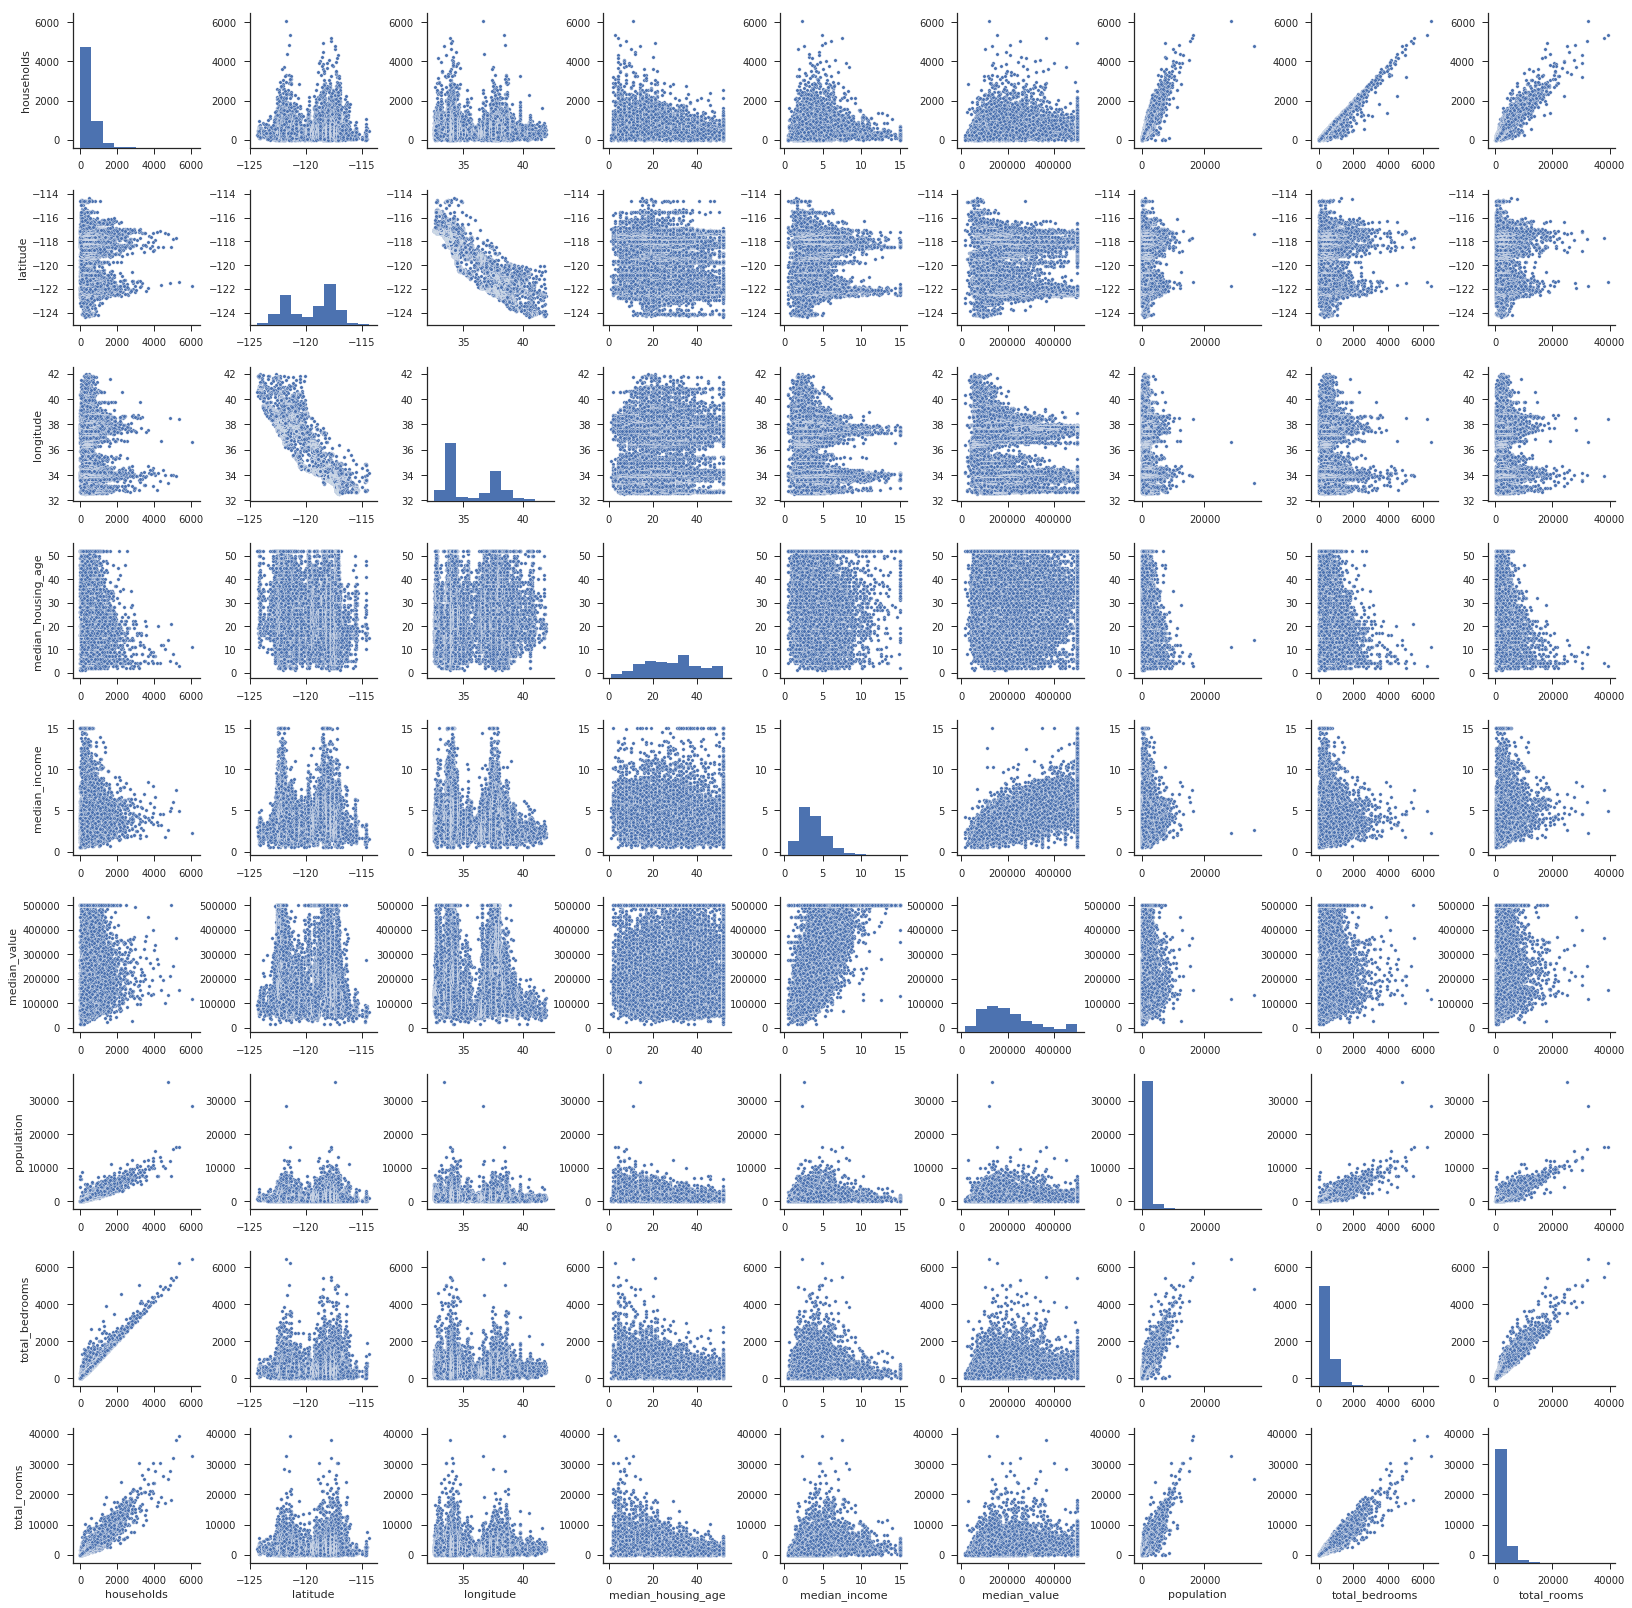

In [17]:
import seaborn as sns
sns.set(style="ticks", color_codes=True )
sns.pairplot(df.toPandas(), markers=".")
plt.show()

### Data Preprocessing

**Add some 'finer' features** to our existing set of features.
This are qualitative information that could help us in predicting the median_value of a house

1. Rooms per household :  number of rooms in households per block group
2. Population per household :  how many people live in households per block group 
3. Bedrooms per room : gives you an idea about how many rooms are bedrooms per block group

In [18]:
from pyspark.sql.functions import *
# 1.
roomsPerHousehold = df['total_rooms']/df['households']

# 2.
populationPerHousehold = df['population']/df['households']

# 3.
bedroomsPerRoom = df['total_bedrooms']/df['total_rooms']

# Add the new columns to `df`
df = df.withColumn("roomsPerHousehold",roomsPerHousehold) \
       .withColumn("populationPerHousehold",populationPerHousehold) \
       .withColumn("bedroomsPerRoom", bedroomsPerRoom)
   
# Check what is the output
df.first()

Row(households=126.0, latitude=-122.23, longitude=37.88, median_housing_age=41.0, median_income=8.3252, median_value=452600.0, population=322.0, total_bedrooms=129.0, total_rooms=880.0, roomsPerHousehold=6.984126984126984, populationPerHousehold=2.5555555555555554, bedroomsPerRoom=0.14659090909090908)

In [19]:
# Adjust the values of `median_value`
# This is simply beacuse they are very high
#df = df.withColumn("median_value", col("median_value")/100000)

In [20]:
# Re-order and select columns
# Features PLUS Target at the end
df = df.select('median_value',
              'total_bedrooms', 
              'population', 
              'households', 
              'median_income', 
              'roomsPerHousehold', 
              'populationPerHousehold', 
              'bedroomsPerRoom'
              )

In [21]:
from pyspark.ml.linalg import DenseVector

# We need to transform each row of feature into a vector ( a continous space of values )
# for the algorithm : in particular a DenseVector
# The density of a vector is defined by the number of empty values it has. 
# lesser empty values, bigger density of the vector

# Define the input_data 
# The median value (row[0]) is our target variable ( the label )
# The rest of the values row[1:] our our features
data = df.rdd.map(lambda row: (row[0], DenseVector(row[1:])))

# Replace df with the new DataFrame
df = spark.createDataFrame(data, ["label", "features"])

In [22]:
df.toPandas().head(4)

,label,features
0,4.526,"[129.0, 322.0, 126.0, 8.3252, 6.98412698413, 2..."
1,3.585,"[1106.0, 2401.0, 1138.0, 8.3014, 6.2381370826,..."
2,3.521,"[190.0, 496.0, 177.0, 7.2574, 8.28813559322, 2..."
3,3.413,"[235.0, 558.0, 219.0, 5.6431, 5.81735159817, 2..."


### Feature Scaling ( Standarization )

At this stage we can see that features are not scaled.

Scaling features is a very common pre-processing step and can improve the convergence rate during the optimization process, and also prevents against features with very large variances exerting an overly large influence during model training.

In [23]:
from pyspark.ml.feature import StandardScaler

standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame to the scaler
scaler = standardScaler.fit(df)

# Transform the data in df using the scaler
scaled_df = scaler.transform(df)

# Inspect the result
scaled_df.take(2)

[Row(label=4.526, features=DenseVector([129.0, 322.0, 126.0, 8.3252, 6.9841, 2.5556, 0.1466]), features_scaled=DenseVector([0.3062, 0.2843, 0.3296, 4.3821, 2.8228, 0.2461, 2.5264])),
 Row(label=3.585, features=DenseVector([1106.0, 2401.0, 1138.0, 8.3014, 6.2381, 2.1098, 0.1558]), features_scaled=DenseVector([2.6255, 2.1202, 2.9765, 4.3696, 2.5213, 0.2031, 2.6851]))]

In [24]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2],seed=1234)
print('Training records : %d' % train_data.count())
print('Test records : %d ' % test_data.count())

Training records : 16514
Test records : 4126 


### Model Creation

In [25]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="label", maxIter=10, elasticNetParam=0.8)

# Fit the data to the models
linearModelA = lr.fit(train_data,{lr.regParam:0.1})
linearModelB = lr.fit(train_data,{lr.regParam:0.3})
linearModelC = lr.fit(train_data,{lr.regParam:0.6})
# Generate predictions for models
predictedA = linearModelA.transform(test_data)
predictedB = linearModelB.transform(test_data)
predictedC = linearModelC.transform(test_data)

### Model Evaluation

In [26]:
predictedB.toPandas().head(10)

,label,features,features_scaled,prediction
0,0.14999,"[73.0, 85.0, 38.0, 1.6607, 6.71052631579, 2.23...","[0.173294630003, 0.0750576980601, 0.0993906430...",1.449151
1,0.14999,"[239.0, 490.0, 164.0, 2.1, 3.7743902439, 2.987...","[0.567361870832, 0.432685553523, 0.42894909115...",1.570503
2,0.14999,"[267.0, 628.0, 225.0, 4.1932, 3.56888888889, 2...","[0.633831043984, 0.554543933903, 0.58849722872...",2.148728
3,0.34400,"[121.0, 530.0, 115.0, 2.1458, 3.07826086957, 4...","[0.287241783978, 0.468006823198, 0.30078747245...",1.583155
4,0.39800,"[316.0, 672.0, 241.0, 1.9107, 4.91286307054, 2...","[0.750152097, 0.593397330546, 0.630345920544, ...",1.518211
5,0.40000,"[185.0, 318.0, 115.0, 1.6833, 6.75652173913, 2...","[0.439171322611, 0.280804093919, 0.30078747245...",1.455394
6,0.42100,"[564.0, 1155.0, 431.0, 2.0441, 5.9837587007, 2...","[1.3388790592, 1.01990166188, 1.12729913591, 1...",1.555061
7,0.42500,"[217.0, 805.0, 197.0, 1.25, 4.54822335025, 4.0...","[0.515136091927, 0.710840552217, 0.51526201803...",1.335699
8,0.43800,"[78.0, 284.0, 73.0, 1.5313, 5.80821917808, 3.8...","[0.185164125209, 0.250781014695, 0.19093465643...",1.413405
9,0.43900,"[420.0, 1371.0, 388.0, 2.0335, 4.44845360825, ...","[0.997037597278, 1.21063651812, 1.01483077664,...",1.552133


In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction')
scoreA = evaluator.evaluate(predictedA)
scoreB = evaluator.evaluate(predictedB)
scoreC = evaluator.evaluate(predictedC)
print('Score for model A is : %f' % scoreA )
print('Score for model B is : %f' % scoreB )
print('Score for model C is : %f' % scoreC )

Score for model A is : 0.890806
Score for model B is : 0.891992
Score for model C is : 0.891992


In [28]:
# Get the RMSE ( standard deviation of the residuals ) residual = predicted - observed
# It indicates the absolute fit of the model to the data ,
# or how close the observed data points are to the model's predicted values
# The smaller an RMSE value, the closer predicted and observed values are.
linearModelA.summary.rootMeanSquaredError

0.816322787138538

In [29]:
# Get the R2
# The R2 (coefficient of determination) is a measure 
# of the dispersion of the data with respect to fitted regression line, and varies between 0-100% (or 0-1)
# 0% indicates that the model explains none of the variability of the response data around its mean, 
# and 100% indicates the opposite: it explains all the variability. 
# In gemneral , the higher the R-squared, the better the model fits your data.
linearModelA.summary.r2

0.492042333203234

In [30]:
spark.stop()